In [ ]:
"""
PROEBLEMs:

validation rn --> change loading images train, we've done it before

Also raro con numero de clases y numero de canales

TODOs:

implement unet with --> segmentation models and transfer learning: https://github.com/qubvel/segmentation_models
different weights to classes, hence, number of clases? --> https://github.com/ianhi/AC295-final-project-JWI/blob/master/lib/Segmentation.py // https://towardsdatascience.com/how-we-built-an-easy-to-use-image-segmentation-tool-with-transfer-learning-546efb6ae98 // https://www.tensorflow.org/tutorials/structured_data/imbalanced_data --> it'll depend on the magnitude of the loss functions
test my model with oxford --> https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet /// https://www.kaggle.com/spidy20/image-segmentation-using-unet-tensorflow
check the activation of layers --> https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4
implement shuffling in the generator --> https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
"""

In [1]:
import os
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#Run from server

gpu4 = "GPU-71b4cdfc-e381-0b98-9b24-4fc06284b496" 
gpu5 = "GPU-99d0769a-9f86-4800-a40e-2320dddcf5d1" 
gpu6 = "GPU-7423cfb5-cff4-ec4d-7e96-ea6e1591d56f"
gpu7 = "GPU-c0a8738f-6dd0-1b78-c38f-4969fd3886a8"

os.environ["CUDA_VISIBLE_DEVICES"]= gpu6 + "," + gpu5

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:XLA_GPU:1', '/device:GPU:0', '/device:GPU:1']


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [46]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_DEPTH = 155

IMG_HEIGHT_UNET = 256
IMG_WIDTH_UNET = 256

N_IMG = 369
length_file = IMG_DEPTH * N_IMG
h5py_file_name = 'training.hdf5'
smooth = 1

___

Generating the data and creating data arrays

In [ ]:
ImgDir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
features_path = list()
labels_path = list()
count = 0
lim = 10

for folder in os.listdir(ImgDir):
    count +=1
    if 'Training' in folder:
        new_dir = os.path.join(ImgDir,folder)
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(os.path.join(new_dir, files))
            if 'seg' in files:
                labels_path.append(os.path.join(new_dir, files))

print(len(features_path))
print(len(labels_path))


In [ ]:
img_conc_features = np.zeros((len(features_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = features_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_features[i,:,:,:] = imgarr
    
img_conc_features = np.concatenate(img_conc_features,axis=2)
print(np.shape(img_conc_features))

In [ ]:
img_conc_labels = np.zeros((len(labels_path),IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
path = labels_path

for file, i in zip(path,range(len(path))):
    img = nib.load(file)
    imgarr = img.get_fdata()
    img_conc_labels[i,:,:,:] = imgarr
    
img_conc_labels = np.concatenate(img_conc_labels,axis=2)
print(np.shape(img_conc_labels))

In [ ]:
with h5py.File(os.path.join('..','data',h5py_file_name), 'a') as f:
    f.create_dataset("features", data=img_conc_features, compression="gzip")
    f.create_dataset("labels", data=img_conc_labels, compression="gzip")

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["features"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

In [ ]:
hdf5_store_Brats = h5py.File(os.path.join('..','data',h5py_file_name), "r")
test_img = hdf5_store_Brats["labels"][:, :, 100]
plt.imshow(test_img, cmap ='gray')
hdf5_store_Brats.close()

___

Load data and model

In [92]:
# images = X_nib.get_fdata()
# labels = y_nib.get_fdata()

#https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

with h5py.File(os.path.join('..','data',h5py_file_name), "r") as f:
    #images_train = f["features"][()] #the whole dataset: 57195 images
    #labels_train = f["labels"][()]
    
    images = f["features"]
    images_train = images[:,:,:300] #taking a subsample
    
    labels = f["labels"]
    labels_train = labels[:,:,:300]

batch_size = 30 # 

In [93]:
np.shape(images_train)

(240, 240, 300)

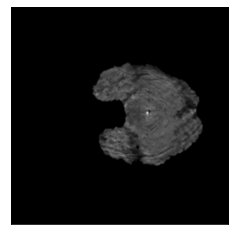

In [94]:
plt.imshow(images_train[:,:,42], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

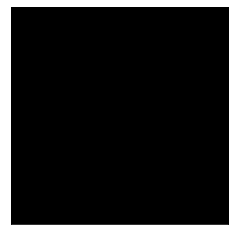

In [95]:
plt.imshow(labels_train[:,:,42], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

____

In [96]:
#https://towardsdatascience.com/using-custom-building-blocks-in-tensorflow-2-0-550b88eb7aa2

class My_Custom_Generator(tf.keras.utils.Sequence):
  
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = True
        
#     def on_epoch_end(self):
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)


    def __getitem__(self, idx) :
        batch_x = self.images[:,:,idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[:,:,idx * self.batch_size : (idx+1) * self.batch_size]
        #240,240,32
        batch_x /= 255.
        batch_y /= 255.

#         train_image = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,3))
#         train_label = np.zeros((batch_size,IMG_HEIGHT,IMG_WIDTH,3))
        
        train_image = np.zeros((batch_size,IMG_HEIGHT_UNET,IMG_WIDTH_UNET,3))
        train_label = np.zeros((batch_size,IMG_HEIGHT_UNET,IMG_WIDTH_UNET,3))
        
        for i in range(batch_size):
            
#             X_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)
#             y_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)

            X_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)
            y_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3), np.float32)

            X_new[:IMG_HEIGHT,:IMG_WIDTH,0] = batch_x[:,:,i]
            X_new[:IMG_HEIGHT,:IMG_WIDTH,1] = batch_x[:,:,i]
            X_new[:IMG_HEIGHT,:IMG_WIDTH,2] = batch_x[:,:,i]
            
            y_new[:IMG_HEIGHT,:IMG_WIDTH,0] = batch_y[:,:,i]
            y_new[:IMG_HEIGHT,:IMG_WIDTH,1] = batch_y[:,:,i]
            y_new[:IMG_HEIGHT,:IMG_WIDTH,2] = batch_y[:,:,i]
            
#             X_new[:,:,0] = batch_x[:,:,i]
#             X_new[:,:,1] = batch_x[:,:,i]
#             X_new[:,:,2] = batch_x[:,:,i]

#             y_new[:,:,0] = batch_y[:,:,i]
#             y_new[:,:,1] = batch_y[:,:,i]
#             y_new[:,:,2] = batch_y[:,:,i]

            train_image[i,:,:,:] = X_new
            train_label[i,:,:,:] = y_new

           
          # Checking the input images in the network  
            
#         plt.imshow(train_image[10,:,:,1], cmap = 'gray')
#         plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#         plt.show()
        
#         plt.imshow(train_label[10,:,:,1], cmap = 'gray')
#         plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#         plt.show()
        
        return np.array(train_image), np.array(train_label)

my_training_batch_generator = My_Custom_Generator(images_train, labels_train, batch_size)

Correct input in the netowrk

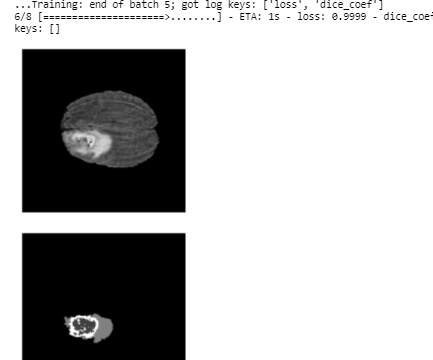

In [97]:
class printbatch(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, epoch, logs={}):

        res_dir = os.path.join("..","data","test_images")

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

    
    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        
        res_dir = os.path.join("..","data","test_images")
        
        test_img_feat_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz")
        test_img_label_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_seg.nii.gz")
        
        img_feat = nib.load(test_img_feat_dir)
        imgarr_feat = img_feat.get_fdata()
        test_img_feat_slice = imgarr_feat[:,:,100]
        
        img_label = nib.load(test_img_label_dir)
        imgarr_label = img_label.get_fdata()
        test_img_label_slice = imgarr_label[:,:,100]
        
        test_img = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET,3), np.float32)

        test_img[:IMG_HEIGHT,:IMG_WIDTH,0] = test_img_feat_slice
        test_img[:IMG_HEIGHT,:IMG_WIDTH,1] = test_img_feat_slice
        test_img[:IMG_HEIGHT,:IMG_WIDTH,2] = test_img_feat_slice
        
        p = np.reshape(test_img, (1, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3))
        
        prediction = self.model.predict(p)

#         plt.figure()
#         plt.imshow(test_img_feat_slice, cmap ='gray')
#         plt.figure()
#         plt.imshow(test_img_label_slice, cmap ='gray')
#         plt.figure()
#         plt.imshow(prediction[0,:,:,:], cmap ='gray')
    
        x_img = os.path.join(res_dir,"X_input.jpg")
        y_img = os.path.join(res_dir,"Y_truth.jpg")
        predicted_img = os.path.join(res_dir,f"{epoch}_Y_predicted.jpg")

        cv2.imwrite(x_img, test_img * 255.)
        cv2.imwrite(y_img, test_img_label_slice * 255.)
        cv2.imwrite(predicted_img, prediction[0,:,:,:] * 255.)
        
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

pb = printbatch()

Model 1

In [ ]:


import segmentation_models as sm
model = sm.Unet('resnet34', classes = 3, input_shape=(IMG_HEIGHT_UNET, IMG_WIDTH_UNET, 3))
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
model.fit_generator(my_training_batch_generator, epochs = 1, verbose=2, callbacks=[pb], validation_data=None, class_weight=None)

Model 2

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])   

    #model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

    model.compile(optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [18]:
model2=get_model()
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 240, 240, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

In [19]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()

In [29]:
# modify the fit_generator call to include the callback pb
training_history = model2.fit_generator(generator = my_training_batch_generator, epochs = 10, verbose=1, callbacks=[pb], validation_data=None, class_weight=None)

../data/test_images directory already exist
Epoch 1/10
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_coef']
1/8 [==>...........................] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9033e-06...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_coef']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_coef']
3/8 [==========>...................] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9033e-06...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_coef']
4/8 [==============>...............] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9033e-06...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice_coef']
5/8 [=================>............] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9034e-06...Training: start of batch 5; got log k

8/8 [==============================] - 2s 253ms/step - loss: 1.0000 - dice_coef: 2.9067e-06
Epoch 6/10
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'dice_coef']
1/8 [==>...........................] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9073e-06...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'dice_coef']
2/8 [======>.......................] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9074e-06...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'dice_coef']
3/8 [==========>...................] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9075e-06...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'dice_coef']
4/8 [==============>...............] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9075e-06...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'dice

6/8 [=====================>........] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9122e-06...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'dice_coef']
7/8 [=========================>....] - ETA: 0s - loss: 1.0000 - dice_coef: 2.9123e-06...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'dice_coef']
End epoch 9 of training; got log keys: ['loss', 'dice_coef']
8/8 [==============================] - 2s 243ms/step - loss: 1.0000 - dice_coef: 2.9124e-06


Image visualization of training

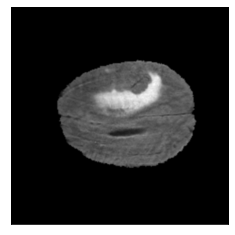

In [70]:
test_img_feat_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz")
img_feat = nib.load(test_img_feat_dir)
imgarr_feat = img_feat.get_fdata()
test_img_feat_slice = imgarr_feat[:,:,100]
test_img = np.zeros((240, 240 ,3), np.float32)

test_img[:,:,0] = test_img_feat_slice
test_img[:,:,1] = test_img_feat_slice
test_img[:,:,2] = test_img_feat_slice

plt.imshow(test_img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

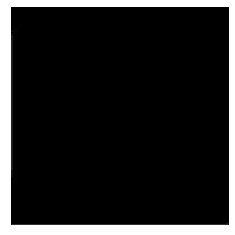

In [105]:
directory_predicted = os.path.join("..","data","test_images","3_Y_predicted.jpg")
directory_y = os.path.join("..","data","test_images","Y_truth.jpg")
directory_X = os.path.join("..","data","test_images","X_input.jpg")

img = cv2.imread(directory_predicted,0)

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

____

In [ ]:
import SimpleITK as sitk
img_flair = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz"))
nda_flair = sitk.GetArrayViewFromImage(img_flair)
print(np.shape(nda_flair))

for i in range(len(nda_flair[:,1,1])):

    X_new = np.zeros((240, 240 ,3), np.float32)

    X_new[:,:,0] = batch_x[:,:,i]
    X_new[:,:,1] = batch_x[:,:,i]
    X_new[:,:,2] = batch_x[:,:,i]

    train_image.append(X_new)

In [ ]:
def generator():
    
    data_length = len(X_nib.get_fdata()[1,1,:])
    chunks = np.floor(data_length / batch_size)
    print('A')
    X = X_nib.get_fdata()
    y = y_nib.get_fdata()
    print('B')
    X /= 255
    y /= 255
    print('C')
    
    while True:
        
        for i in range(int(chunks)):
            X_yield = []
            y_yield = []

            X_mod = X[:,:,i*32:(i+1)*32]
            y_mod = y[:,:,i*32:(i+1)*32]
            print(np.shape(X_mod))

            for j in range(32):
                X_new = np.zeros((240, 240 ,3), np.uint8)
                X_new[:,:,0] = X_mod[:,:,j]
                X_new[:,:,1] = X_mod[:,:,j]
                X_new[:,:,2] = X_mod[:,:,j]

                X_yield.append(X_new)
                print(np.shape(X_yield))

                y_new = np.zeros((240, 240 ,3), np.uint8)
                y_new[:,:,0] = y_mod[:,:,j]
                y_new[:,:,1] = y_mod[:,:,j]
                y_new[:,:,2] = y_mod[:,:,j]

                y_yield.append(y_new)

            yield np.reshape(X_yield,(32,240,240,3)), np.reshape(y_yield,(32,240,240,3))
        

my_generator = generator()